In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy
from mpl_toolkits import mplot3d
from matplotlib import cm
sys.path.append("FixedStrides")
from main import *
results_wolant = pd.read_csv('ip32_wolant_results.csv', sep=';')
results_fst = pd.read_csv('ip32_fst_results.csv', sep=';')
results_equal_dist = pd.read_csv('ip32_equal_dist_results.csv', sep=';')
results_random = pd.read_csv('ip32_random_results.csv', sep=';')
results_random_shuffled = pd.read_csv('ip32_random_shuffled.csv', sep=';')
# results_au = pd.read_csv('ipResults_home_gtx980_australia.csv', sep=';')
# results_au_32bit = pd.read_csv('ip_32bit_au.csv', sep=';')
# results_tokyo = pd.read_csv('ip_32bit_tokyo.csv', sep=';')
# results_au_32bit.drop(results_au_32bit.columns[len(results_au_32bit.columns)-1], axis=1, inplace=True)  # delete NaN column
# results_tokyo.drop(results_tokyo.columns[len(results_tokyo.columns)-1], axis=1, inplace=True)  # delete NaN column

In [2]:
def plot_prefix_distribution(prefixes):
    lengths = utils.get_lengths(prefixes)
    plt.bar(range(1, len(lengths) + 1), lengths, align='center')
    plt.xlabel('Prefix length in bits')
    plt.ylabel('Num occurrences')
    plt.title('Prefix length distribution')
    plt.show()

In [3]:
# prefixes_au = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_australia_012016.txt')
prefixes_tokyo = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_tokyo_012016.txt')
node_counts_tokyo = utils.get_node_counts(prefixes_tokyo)

Read 576846 prefixes from file in 7.490567684173584 seconds


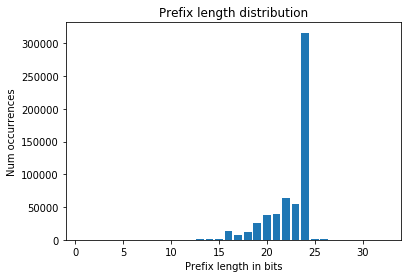

In [4]:
# plot_prefix_distribution(prefixes_au)
plot_prefix_distribution(prefixes_tokyo)

In [5]:
def get_empty_node_stats(tree_levels, strides):
    # Calculate number of empty child pointers in all nodes at each level
    # For example, if we have 100 nodes in level 1 (second level)
    # And the config for root node is 8, then it means the root node has 2^8 - 100 empty/null child pointers
    # TODO move this to utils.get_stats()
    num_empty_pointers_per_lvl = []
    percentage_empty_pointers_per_lvl = []
    total_num_pointers = 0
    for i in range(len(tree_levels) - 1):
        total_num_pointers_in_curr_lvl = tree_levels[i] * (2 ** strides[i])
        num_empty_pointers_in_curr_lvl = total_num_pointers_in_curr_lvl - tree_levels[i + 1]
        total_num_pointers += total_num_pointers_in_curr_lvl
        num_empty_pointers_per_lvl.append(num_empty_pointers_in_curr_lvl)
        percentage_empty_pointers_per_lvl.append(float(round(100 * num_empty_pointers_in_curr_lvl / total_num_pointers_in_curr_lvl, 2)))
    total_empty_pointer_percentage = float(round(100 * sum(num_empty_pointers_per_lvl) / total_num_pointers, 2))
    return num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage
        


def append_stats(row: pd.Series, nodes: list):
    strides = row['Config'].replace('{', ' ').replace('}',' ').replace(',',' ').split()
    strides = [int(x) for x in strides]
    tree_levels = row['TreeLevels'].replace('{', ' ').replace('}',' ').replace(',',' ').split()
    tree_levels = [int(x) for x in tree_levels]
    num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage = get_empty_node_stats(tree_levels, strides)
    num_empty_pointers_per_lvl = str(num_empty_pointers_per_lvl)
    percentage_empty_pointers_per_lvl = str(percentage_empty_pointers_per_lvl)
    tmp, strides_nodes, cost, percent = utils.get_stats(nodes, strides, ignore_last_level=True)
    build_and_find = float(row['Build']) + float(row['Find'])
    build_and_match = float(row['Build']) + float(row['Match'])
    match_and_find = float(row['Match']) + float(row['Find'])
    return pd.Series([cost, percent, build_and_find, build_and_match, match_and_find, num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage])

def append_stats_to_df(df: pd.DataFrame):
    newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind', 'EmptyPointerLevels', 'PercentEmptyPointerLevels', 'TotalEmptyPointerPercentage']
    # For now assume Tokyo dataset
    newcols = df.apply(lambda row: append_stats(row, node_counts_tokyo), axis=1)
    newcols.columns = newcol_names
    return df.join(newcols)

In [6]:
results_wolant = append_stats_to_df(results_wolant)
results_fst = append_stats_to_df(results_fst)
results_equal_dist = append_stats_to_df(results_equal_dist)
results_random = append_stats_to_df(results_random)
results_random_shuffled = append_stats_to_df(results_random_shuffled)

In [7]:
# results_wolant = results_wolant.sort_values('RandomMatch')
# results_wolant[['Config', 'Match', 'RandomMatch', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

# results_fst = results_fst.sort_values('RandomMatch')
# results_fst[['Config', 'Match', 'RandomMatch', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

# results_equal_dist = results_equal_dist.sort_values('Match')
# results_equal_dist[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

In [8]:
results_wolant = results_wolant.sort_values('RandomMatch')
results_wolant[['Config', 'TreeMemoryUniqueOnly', 'MaxItemsPerLevel', 'PercentEmptyPointerLevels', 'RandomMatch', 'Match', 'Find', 'ItemsPerLevel', 'Build', 'EmptyPointerLevels']]

,Config,TreeMemoryUniqueOnly,MaxItemsPerLevel,PercentEmptyPointerLevels,RandomMatch,Match,Find,ItemsPerLevel,Build,EmptyPointerLevels
11,"{8, 2, 2, 2, 2, 2, 2, 2, 2, 8}",2946048,371291,"[83.98, 57.32, 40.71, 38.7, 41.95, 48.92, 34.2...",0.580928,1.169950,0,"{16, 49, 365, 1522, 14744, 20015, 63408, 10387...",29.4939,"[215, 94, 114, 257, 683, 1849, 2646, 2918, 68017]"
12,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3551560,316089,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",0.590752,2.243840,0,"{0, 0, 0, 0, 0, 0, 0, 16, 13, 36, 100, 265, 50...",81.1636,"[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
7,"{8, 4, 4, 2, 2, 2, 2, 8}",2944456,371291,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 97.76]",0.605088,1.063970,0,"{16, 414, 16266, 20015, 63408, 103872, 371291,...",25.7936,"[215, 490, 1711, 1849, 2646, 2918, 68017]"
2,"{8, 4, 4, 4, 4, 8}",2769680,475163,"[83.98, 74.7, 64.42, 66.42, 98.08]",0.622816,1.745790,0,"{16, 414, 16266, 83423, 475163, 1564, }",22.5200,"[215, 490, 1711, 10042, 79689]"
10,"{4, 5, 4, 5, 6, 4, 2, 2}",2972080,538571,"[12.5, 88.39, 68.75, 76.79, 98.74, 99.82, 88.59]",1.007520,3.660510,0,"{0, 29, 907, 35775, 538571, 1518, 25, 21, }",25.8190,"[2, 396, 572, 6389, 122025, 24898, 163]"
9,"{4, 4, 4, 4, 8, 8}",3311312,558586,"[12.5, 81.7, 74.7, 64.42, 99.36]",1.427460,10.812800,0,"{0, 16, 414, 16266, 558586, 1564, }",22.0286,"[2, 183, 490, 1711, 240361]"
5,"{8, 8, 4, 4, 8}",2797048,475163,"[83.98, 91.0, 66.42, 98.08]",8.270530,1.617380,0,"{16, 16680, 83423, 475163, 1564, }",18.3793,"[215, 9551, 10042, 79689]"
3,"{8, 8, 2, 2, 2, 2, 8}",2971824,371291,"[83.98, 91.0, 48.92, 34.26, 14.37, 97.76]",8.305540,0.986688,0,"{16, 16680, 20015, 63408, 103872, 371291, 1564, }",24.0876,"[215, 9551, 1849, 2646, 2918, 68017]"
6,"{8, 8, 4, 2, 2, 8}",2970800,371291,"[83.98, 91.0, 66.42, 14.37, 97.76]",8.326300,0.977568,0,"{16, 16680, 83423, 103872, 371291, 1564, }",22.3593,"[215, 9551, 10042, 2918, 68017]"
1,"{8, 8, 8, 8}",3338592,558586,"[83.98, 91.0, 99.36]",8.959420,10.791000,0,"{16, 16680, 558586, 1564, }",18.0983,"[215, 9551, 240361]"


In [9]:
results_fst = results_fst.sort_values('MaxItemsPerLevel')
results_fst[['Config', 'TreeMemoryUniqueOnly', 'RandomMatch', 'Match', 'Find', 'ItemsPerLevel', 'MaxItemsPerLevel', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,Config,TreeMemoryUniqueOnly,RandomMatch,Match,Find,ItemsPerLevel,MaxItemsPerLevel,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
3,"{18, 3, 2, 1, 8}",4206824,68.426700,0.747040,0,"{36711, 103489, 118993, 316089, 1564, }",316089,99.444746,"[99.26, 40.53, 8.08, 97.69]",19.8994,"{1,1931,9187,33779,1559,}","[260213, 6261, 2969, 65999]"
4,"{17, 3, 2, 1, 1, 8}",3837824,45.131900,1.045860,0,"{24107, 76012, 103872, 55202, 316089, 1564, }",316089,93.501291,"[98.99, 51.91, 14.37, 2.9, 97.69]",21.5684,"{1,1320,5078,17394,33779,1559,}","[129752, 5482, 2918, 1009, 65999]"
5,"{17, 3, 2, 1, 1, 3, 5}",3888256,45.678500,0.942944,0,"{24107, 76012, 103872, 55202, 316089, 1501, 63, }",316089,93.986481,"[98.99, 51.91, 14.37, 2.9, 97.69, 99.49]",23.9807,"{1,1320,5078,17394,33779,1559,63,}","[129752, 5482, 2918, 1009, 65999, 12409]"
6,"{13, 4, 3, 2, 1, 1, 3, 5}",3415496,2.770620,1.069090,0,"{936, 23171, 76012, 103872, 55202, 316089, 150...",316089,91.418692,"[96.83, 68.27, 51.91, 14.37, 2.9, 97.69, 99.49]",25.7019,"{1,260,1320,5078,17394,33779,1559,63,}","[7932, 2840, 5482, 2918, 1009, 65999, 12409]"
7,"{12, 4, 2, 2, 2, 1, 1, 3, 5}",3408608,1.366780,0.948928,0,"{430, 16266, 20015, 63408, 103872, 55202, 3160...",316089,90.352937,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",27.2385,"{1,166,945,1931,5078,17394,33779,1559,63,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 12..."
8,"{12, 4, 2, 2, 2, 1, 1, 2, 2, 4}",3394176,1.546270,1.012060,0,"{430, 16266, 20015, 63408, 103872, 55202, 3160...",316089,90.201315,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",29.7040,"{1,166,945,1931,5078,17394,33779,1559,442,46,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 57..."
9,"{12, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",3392064,1.387200,1.023360,0,"{430, 16266, 20015, 63408, 103872, 55202, 3160...",316089,90.168056,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",32.5335,"{1,166,945,1931,5078,17394,33779,1559,442,63,30,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 57..."
10,"{8, 4, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",3379696,0.566528,1.020740,0,"{16, 414, 16266, 20015, 63408, 103872, 55202, ...",316089,90.136753,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 2.9,...",38.6295,"{1,41,166,945,1931,5078,17394,33779,1559,442,6...","[215, 490, 1711, 1849, 2646, 2918, 1009, 65999..."
11,"{8, 4, 4, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3}",3383536,0.564224,1.133860,0,"{16, 414, 16266, 20015, 63408, 103872, 55202, ...",316089,90.109119,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 2.9,...",35.4393,"{1,41,166,945,1931,5078,17394,33779,1559,1017,...","[215, 490, 1711, 1849, 2646, 2918, 1009, 65999..."
12,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3551560,0.572352,2.255780,0,"{0, 0, 0, 0, 0, 0, 0, 16, 13, 36, 100, 265, 50...",316089,100.000000,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",81.3095,"{1,2,4,8,14,25,32,38,41,52,70,107,166,260,407,...","[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."


In [10]:
results_equal_dist = results_equal_dist.sort_values('RandomMatch')
results_equal_dist[['Config', 'RandomMatch', 'Match', 'Find', 'ItemsPerLevel', 'MaxItemsPerLevel', 'TreeMemoryUniqueOnly', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,Config,RandomMatch,Match,Find,ItemsPerLevel,MaxItemsPerLevel,TreeMemoryUniqueOnly,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
4,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.527776,3.125980,0,"{0, 0, 0, 0, 0, 0, 0, 16, 13, 36, 100, 265, 50...",316089,3551560,100.000000,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",83.7463,"{1,2,4,8,14,25,32,38,41,52,70,107,166,260,407,...","[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
3,"{20, 1, 1, 1, 1, 8}",199.328000,0.847552,0,"{100119, 40081, 63791, 55202, 316089, 1564, }",316089,7561408,136.816479,"[99.52, 9.54, 5.33, 2.9, 97.69]",24.1171,"{1,5078,9187,17394,33779,1559,}","[1043498, 969, 980, 1009, 65999]"
2,"{20, 2, 1, 1, 8}",199.490000,0.763104,0,"{100119, 103872, 55202, 316089, 1564, }",316089,7455000,132.745921,"[99.52, 14.37, 2.9, 97.69]",20.2838,"{1,5078,17394,33779,1559,}","[1043498, 2918, 1009, 65999]"
1,"{21, 2, 1, 8}",292.847000,0.820192,0,"{140200, 118993, 316089, 1564, }",316089,11469576,185.513142,"[99.56, 8.08, 97.69]",19.2516,"{1,9187,33779,1559,}","[2087965, 2969, 65999]"
0,"{22, 1, 9}",452.121000,29.191600,0,"{203991, 55202, 317653, }",317653,19633256,275.912299,"[99.59, 2.9]",19.3284,"{1,17394,33779,}","[4176910, 1009]"


In [11]:
results_random = results_random.sort_values('RandomMatch')
results_random[['Config', 'RandomMatch', 'Match', 'ItemsPerLevel', 'MaxItemsPerLevel', 'TreeMemoryUniqueOnly', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,Config,RandomMatch,Match,ItemsPerLevel,MaxItemsPerLevel,TreeMemoryUniqueOnly,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
725,"{2, 7, 2, 2, 1, 4, 5, 3, 3, 3}",0.408032,1.17066,"{0, 29, 136, 771, 1016, 34759, 222482, 317211,...",317211,3978856,214.014140,"[0.0, 89.84, 48.56, 39.25, 21.73, 70.35, 45.33...",30.6916,"{1,4,52,107,260,407,1931,33779,442,30,}","[0, 460, 101, 168, 113, 4581, 28013, 269790, 3..."
602,"{7, 2, 1, 1, 3, 2, 1, 6, 9}",0.429120,1.33008,"{0, 29, 36, 100, 1787, 14744, 7411, 235086, 31...",317653,2959000,140.575112,"[70.31, 65.79, 32.69, 23.57, 52.45, 41.95, 30....",27.9213,"{1,38,52,70,107,407,945,1320,33779,}","[90, 100, 34, 33, 449, 683, 570, 50701]"
507,"{4, 7, 2, 3, 5, 2, 2, 7}",0.430816,0.94784,"{0, 165, 771, 15760, 123504, 118993, 316636, 1...",316636,3495856,127.013636,"[12.5, 94.03, 39.25, 54.57, 69.62, 8.08, 99.25]",26.6171,"{1,14,107,260,945,9187,33779,1017,}","[2, 1685, 168, 1135, 21053, 2969, 134099]"
554,"{1, 3, 7, 5, 1, 3, 3, 9}",0.432064,0.87968,"{0, 0, 165, 16531, 7411, 76012, 159074, 317653, }",317653,2870896,71.159443,"[0.0, 12.5, 94.03, 72.4, 30.16, 51.91, 16.85]",27.1547,"{1,2,14,107,945,1320,5078,33779,}","[0, 2, 1685, 2479, 570, 5482, 6845]"
794,"{2, 3, 6, 1, 3, 4, 3, 1, 1, 8}",0.441184,1.14189,"{0, 0, 165, 265, 3292, 58561, 141708, 55202, 3...",316089,3319624,98.709625,"[0.0, 21.88, 93.31, 22.43, 52.48, 70.28, 27.55...",30.1098,"{1,4,25,107,166,631,3001,17394,33779,1559,}","[0, 7, 1493, 48, 697, 7095, 6614, 1009, 65999]"
...,...,...,...,...,...,...,...,...,...,...,...
321,"{6, 1, 16, 1, 1, 7}",126.778000,100.65100,"{0, 0, 259193, 316089, 547, 1017, }",316089,12843712,469.680885,"[50.0, 40.62, 98.64, 97.69, 67.38]",22.9505,"{1,32,38,33779,1559,1017,}","[32, 26, 2456589, 65999, 2101]"
79,"{9, 16, 7}",145.607000,827.23700,"{29, 575800, 1017, }",575800,15949592,1610.736784,"[89.84, 99.97]",15.7215,"{1,52,1017,}","[460, 3406855]"
91,"{9, 15, 8}",146.480000,821.38900,"{29, 575253, 1564, }",575253,9138184,805.384044,"[89.84, 99.91]",16.3322,"{1,52,1559,}","[460, 1702377]"
663,"{2, 6, 1, 16, 3, 1, 1, 1, 1}",146.487000,824.50400,"{0, 16, 13, 575800, 971, 16, 9, 0, 21, }",575800,15983776,1611.130512,"[0.0, 83.98, 36.59, 99.97, 99.43, 67.39, 65.0,...",28.7182,"{1,4,41,52,1017,46,30,21,21,}","[0, 215, 30, 3406855, 8090, 62, 39, 21]"


In [12]:
results_random_shuffled = results_random_shuffled.sort_values('RandomMatch')
results_random_shuffled[['Config', 'RandomMatch', 'Match', 'ItemsPerLevel', 'MaxItemsPerLevel', 'TreeMemoryUniqueOnly', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,Config,RandomMatch,Match,ItemsPerLevel,MaxItemsPerLevel,TreeMemoryUniqueOnly,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
1267,"{2, 4, 1, 2, 1, 1, 3, 1, 3, 3, 3, 2, 1, 2, 3}",0.444768,1.71974,"{0, 0, 0, 29, 36, 100, 1787, 1770, 32989, 1034...",435082,2838656,101.471343,"[0.0, 50.0, 40.62, 65.79, 32.69, 23.57, 52.45,...",44.7667,"{1,4,32,38,52,70,107,407,631,1931,9187,1559,44...","[0, 32, 26, 100, 34, 33, 449, 183, 3117, 6261,..."
718,"{7, 2, 2, 1, 3, 2, 4, 7, 1, 3}",0.447328,1.52938,"{0, 29, 136, 265, 3292, 20385, 116093, 436600,...",436600,7207208,1079.239298,"[70.31, 65.79, 48.56, 22.43, 52.48, 47.7, 56.5...",33.3621,"{1,38,52,107,166,631,1320,9187,46,30,}","[90, 100, 101, 48, 697, 1204, 11933, 1175890, 62]"
1346,"{3, 3, 1, 2, 2, 2, 1, 4, 1, 1, 1, 1, 6, 2, 1, 1}",0.447648,1.43795,"{0, 0, 0, 29, 136, 771, 1016, 34759, 25572, 37...",372809,7247856,677.712442,"[0.0, 50.0, 40.62, 65.79, 48.56, 39.25, 21.73,...",46.9626,"{1,8,32,38,52,107,260,407,1931,3001,5078,9187,...","[0, 32, 26, 100, 101, 168, 113, 4581, 861, 924..."
1041,"{2, 1, 1, 7, 1, 1, 1, 3, 6, 2, 1, 1, 5}",0.450816,1.48128,"{0, 0, 0, 165, 265, 506, 1016, 22155, 235086, ...",316636,3523224,190.301214,"[0.0, 0.0, 12.5, 94.03, 22.43, 21.69, 21.73, 5...",40.6676,"{1,4,8,14,107,166,260,407,1320,33779,1017,442,...","[0, 0, 2, 1685, 48, 72, 113, 1936, 50701, 1340..."
830,"{7, 3, 1, 5, 1, 1, 2, 3, 1, 7, 1}",0.454944,1.19936,"{0, 65, 100, 16531, 7411, 12604, 63408, 159074...",316089,3962544,104.193323,"[70.31, 76.97, 23.57, 72.4, 30.16, 26.86, 34.2...",36.2823,"{1,38,70,107,945,1320,1931,5078,33779,1559,21,}","[90, 234, 33, 2479, 570, 709, 2646, 6845, 6599..."
...,...,...,...,...,...,...,...,...,...,...,...
7,"{24, 5, 3}",1169.930000,1731.16000,"{575282, 1534, 30, }",575282,69628632,1027.663654,"[99.99, 99.94]",21.9745,"{1,1559,30,}","[16775657, 49858]"
73,"{24, 7, 1}",1170.600000,2731.28000,"{575282, 1543, 21, }",575282,70227216,1033.485933,"[99.99, 99.99]",21.0114,"{1,1559,21,}","[16775657, 199531]"
45,"{24, 1, 7}",1170.790000,1731.37000,"{575282, 547, 1017, }",575282,69449448,1025.844191,"[99.99, 67.38]",21.6079,"{1,1559,1017,}","[16775657, 2101]"
42,"{24, 3, 5}",1170.870000,2735.34000,"{575282, 1501, 63, }",575282,69479232,1026.208084,"[99.99, 99.49]",21.3027,"{1,1559,63,}","[16775657, 12409]"


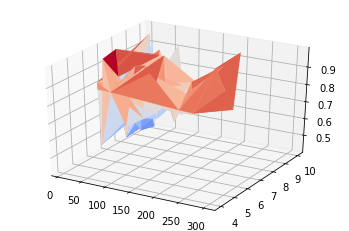

In [13]:
x = results_random['AverageNodeSize'].values
y = results_random['TreeHeight'].values
z = results_random['RandomMatch'].values
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(x[z < 1], y[z < 1], z[z < 1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

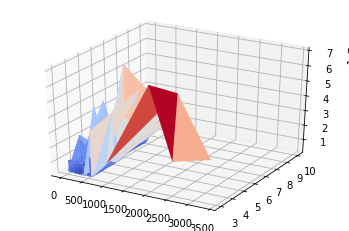

In [14]:
x = results_random['AverageNodeSize'].values
y = results_random['TreeHeight'].values
z = results_random['TreeMemoryUniqueOnly'].values
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)


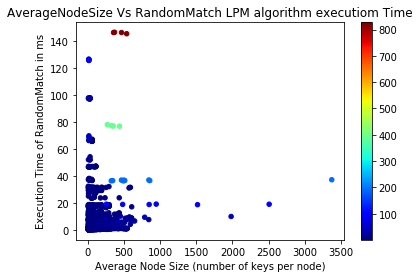

In [39]:
x = results_random['AverageNodeSize'].values
y = results_random['RandomMatch'].values
z = results_random['Depth'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

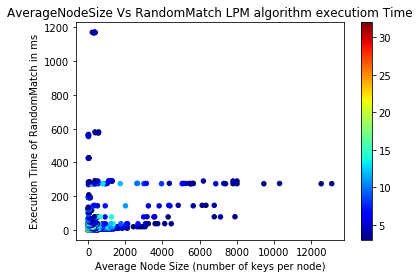

In [40]:
x = results_random_shuffled['AverageNodeSize'].values
y = results_random_shuffled['RandomMatch'].values
z = results_random_shuffled['Depth'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

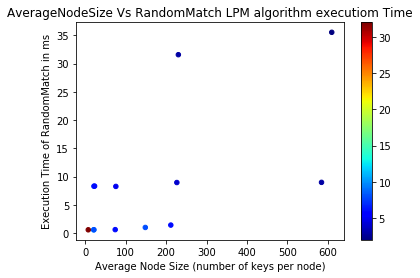

In [17]:
x = results_wolant['AverageNodeSize'].values
y = results_wolant['RandomMatch'].values
z = results_wolant['Depth'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

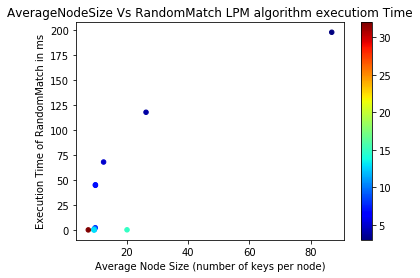

In [18]:
# Seems logarithmic in complexity, normal shape
# Conclusion- PSFT/FST algorithm give us consistency?
x = results_fst['AverageNodeSize'].values
y = results_fst['RandomMatch'].values
z = results_fst['Depth'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

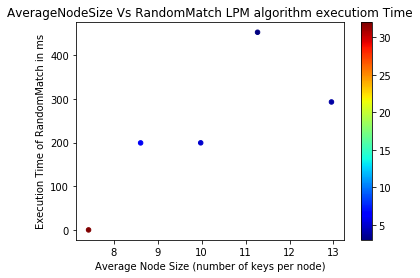

In [19]:
# Also Random
x = results_equal_dist['AverageNodeSize'].values
y = results_equal_dist['RandomMatch'].values
z = results_equal_dist['Depth'].values
plt.title("AverageNodeSize Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Average Node Size (number of keys per node)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

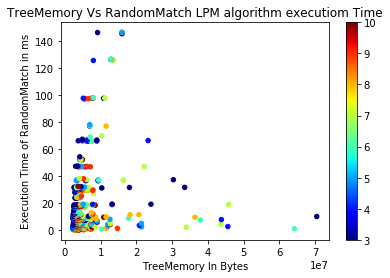

In [20]:
# Notice how fst configurations have much more normal shape
x = results_random['TreeMemoryUniqueOnly'].values
y = results_random['RandomMatch'].values
z = results_random['Depth'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

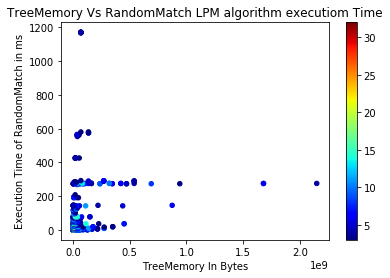

In [21]:
x = results_random_shuffled['TreeMemoryUniqueOnly'].values
y = results_random_shuffled['RandomMatch'].values
z = results_random_shuffled['Depth'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

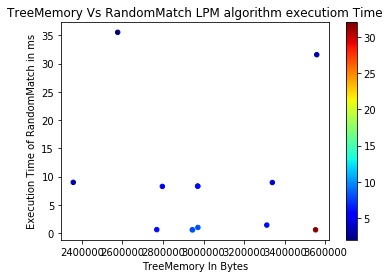

In [22]:
# Completely random
x = results_wolant['TreeMemoryUniqueOnly'].values
y = results_wolant['RandomMatch'].values
z = results_wolant['Depth'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

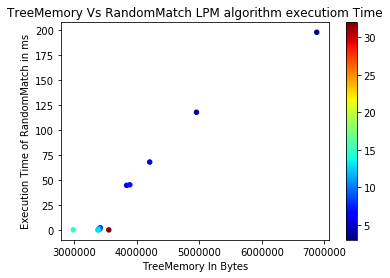

In [23]:
x = results_fst['TreeMemoryUniqueOnly'].values
y = results_fst['RandomMatch'].values
z = results_fst['Depth'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()


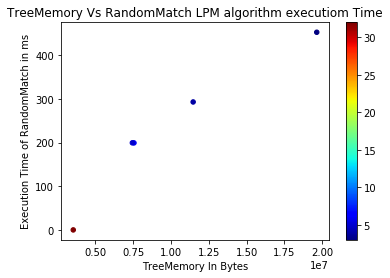

In [24]:
x = results_equal_dist['TreeMemoryUniqueOnly'].values
y = results_equal_dist['RandomMatch'].values
z = results_equal_dist['Depth'].values
plt.title("TreeMemory Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("TreeMemory In Bytes")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()


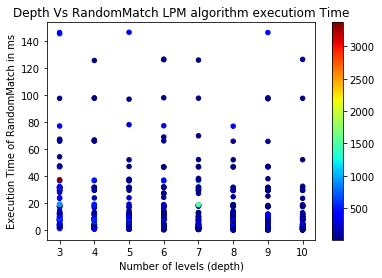

In [25]:
x = results_random['Depth'].values
y = results_random['RandomMatch'].values
z = results_random['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

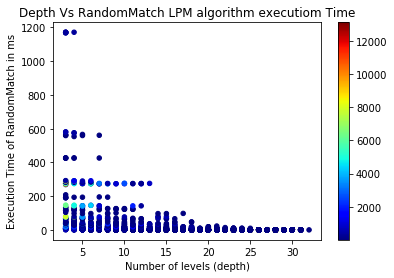

In [26]:
x = results_random_shuffled['Depth'].values
y = results_random_shuffled['RandomMatch'].values
z = results_random_shuffled['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

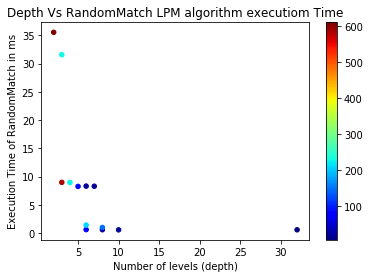

In [27]:
x = results_wolant['Depth'].values
y = results_wolant['RandomMatch'].values
z = results_wolant['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

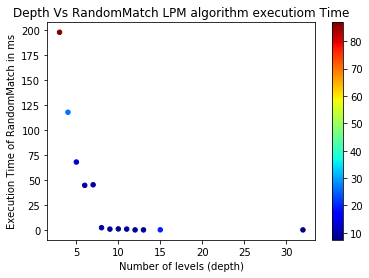

In [28]:
x = results_fst['Depth'].values
y = results_fst['RandomMatch'].values
z = results_fst['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

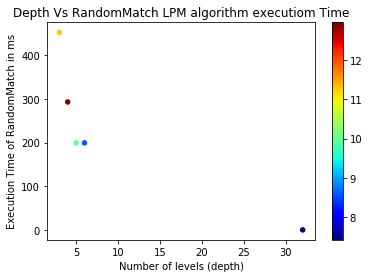

In [29]:
x = results_equal_dist['Depth'].values
y = results_equal_dist['RandomMatch'].values
z = results_equal_dist['AverageNodeSize'].values
plt.title("Depth Vs RandomMatch LPM algorithm executiom Time")
plt.xlabel("Number of levels (depth)")
plt.ylabel("Execution Time of RandomMatch in ms")
plt.scatter(x, y, s=20, c=z, marker='o', cmap = cm.jet)
plt.colorbar()

In [30]:
results_equal_dist.columns
# newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind']
# newcols_au = results_au_32bit.apply(lambda row: append_stats(row, nodes_au), axis=1)
# newcols_tokyo = results_tokyo.apply(lambda row: append_stats(row, nodes_tokyo), axis=1)
# newcols_au.columns = newcol_names
# newcols_tokyo.columns = newcol_names
# results_au_32bit = results_au_32bit.join(newcols_au)
# results_tokyo = results_tokyo.join(newcols_tokyo)
# results_au_32bit = results_au_32bit.sort_values('MatchAndFind')
# results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]
# results_tokyo = results_tokyo.sort_values('TreeMemoryUniqueOnly')
# results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]
# results_au_32bit = results_au_32bit.sort_values('TreeMemoryUniqueOnly')
# results_au_32bit[['Config', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'TreeLevels', 'ChildrenMemory', 'ChildrenCountsMemory', 'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory', 'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_tokyo = results_tokyo.sort_values('Match')
# results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_au_32bit = results_tokyo.sort_values('Find')
# results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Match'])
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Find'])
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Build'])
# results_tokyo['ChildrenMemory'].corr(results_au_32bit['Cost'])
# results_au_32bit['ChildrenMemory'].corr(results_au_32bit['Cost'])
# results_au_32bit['Match'].corr(results_au_32bit['Cost'])
# results_tokyo['Match'].corr(results_au_32bit['Cost'])

Index(['deviceId', 'deviceName', 'Dictionary', 'Load', 'Count', 'Sort',
       'Config', 'Reshape', 'Build', 'RandomCount', 'RandomMatch',
       'RandomSort', 'RandomSortedMatch', 'HitRate', 'TreeMemory',
       'TreeLevels', 'Depth', 'TreeMemoryUniqueOnly', 'ChildrenMemory',
       'ChildrenCountsMemory', 'ScanMemory', 'PreScanMemory',
       'PermuationMemory', 'LengthsMemory', 'MasksPartsMemory',
       'ContainerSumMemory', 'ContainerItemsMemory', 'ContainerStartsMemory',
       'ContainerLengthsMemory', 'AverageNodeSizesLevels', 'AverageNodeSize',
       'TreeHeight', 'NodeSizeToHeightRatio', 'ItemsPerLevel',
       'MaxItemsPerLevel', 'Find', 'Match', 'Unnamed: 37', 'Cost', 'Percent',
       'BuildAndFind', 'BuildAndMatch', 'MatchAndFind', 'EmptyPointerLevels',
       'PercentEmptyPointerLevels', 'TotalEmptyPointerPercentage'],
      dtype='object')